In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import networkx as nx

In [3]:
import pandas as pd

In [199]:
names_df = pd.read_csv('name_list.csv')
all_names = names_df.loc[:,::2].values.flatten()
for i in range(len(all_names)): 
    name = all_names[i]
    if type(name) == str:
        all_names[i] = name.replace(' ','')
#names_df

In [16]:
mentees_df = pd.read_csv('mentees.csv')
#mentees_df

In [71]:
mentors_df = pd.read_csv('mentors.csv')
#mentors_df

In [202]:
role_transformer = {
    'Undergraduate student':'Undergrads',
    'Undergraduate students':'Undergrads',
    'Graduate student':'GradStudents',
    'Graduate students':'GradStudents',
    'Postdoc':'Postdocs',
    'Postdocs':'Postdocs',
    'Faculty':'Faculty',
    'Number of mentees':'Number of mentees'
}

role_ranks = {
    'Undergrads':0,
    'GradStudents':1,
    'Postdocs':2,
    'Faculty':3}

In [140]:
mentee_answers_start = {
    'Undergrads':0,
    'GradStudents':6,
    'Postdocs':11,
    'Faculty':15    
}

mentee_answers_end = {
    'Undergrads':mentee_answers_start['GradStudents'],
    'GradStudents':mentee_answers_start['Postdocs'],
    'Postdocs':mentee_answers_start['Faculty'],
    'Faculty':100} ## dummy index >> length of answers for slicing

In [141]:
mentor_answers_start = {
    'Undergrads':0,
    'GradStudents':3,
    'Postdocs':8,
    'Faculty':14    
}

mentor_answers_end = {
    'Undergrads':mentor_answers_start['GradStudents'],
    'GradStudents':mentor_answers_start['Postdocs'],
    'Postdocs':mentor_answers_start['Faculty'],
    'Faculty':100} ## dummy index >> length of answers for slicing

In [215]:
role_rank_dict = {}
for i,key in enumerate(names_df.keys()[::2][::-1]):
    values = names_df[key].dropna().values
    for name in values:
        role_rank_dict[name.replace(' ','')] = i

In [227]:
class Person(object):
    def __repr__(self):
        return f"{self.role}: {self.name}"
    
    def __init__(self,name,role,raise_error=False):
        self.name = name.replace(' ','')
        self.role = role
        self.raise_error = raise_error
        
        self.mentees_prefr = []
        self.mentors_prefr = []
        
        self.mentees_avoid = []
        self.mentors_avoid = []
        
        self.n_role_mentees = np.zeros(5)
        self.n_role_mentors = np.zeros(4)

    def parse_row_role_mentee(self,row):
        #print('mentee - ',self)
        reported_role = self.check_role(row)
        if reported_role is not None: raise NotImplementedError
        
        ## let's get the answers (and the associated questions) from this row
        questions,answers = self.get_own_answers(row,mentee_answers_start,mentee_answers_end)
        
        ## unpack the preferences
        prefr_avoid_answers = answers[-2:]
        
        ## handle inconsistent ordering, just in case.
        if 'NOT' in questions[-2:][0]: avoids,prefrs = answers[-2:]
        else: prefrs,avoids = answers[-2:]
        
        if prefrs != 'nan': self.mentors_prefr = prefrs.replace(' ','').split(';')
        if avoids != 'nan': self.mentors_avoid = avoids.replace(' ','').split(';')

        for question,answer in zip(questions,answers[:-3]):
            mentor_role = question.split('[')[1].split(']')[0]
            mentor_role = mentor_role.split(' mentor')[0].split(' peer')[0]
            mentor_role = role_transformer[mentor_role]
            role_index = ['Undergrads','GradStudents','Postdocs','Faculty'].index(mentor_role)
        
            self.n_role_mentors[role_index]+= int(eval(answer)) if answer != 'nan' else 0
        
        
    def parse_row_role_mentor(self,row):
        #print('mentor - ',self)
        reported_role = self.check_role(row)
        if reported_role is not None: 
            orig_role = self.role
            self.role = reported_role
        
        ## let's get the answers (and the associated questions) from this row
        questions,answers = self.get_own_answers(row,mentor_answers_start,mentor_answers_end)
        
        ## unpack the preferences
        prefr_avoid_answers = answers[-2:]
        
        ## handle inconsistent ordering, just in case.
        if 'NOT' in questions[-2:][0]: avoids,prefrs = answers[-2:]
        else: prefrs,avoids = answers[-2:]
        
        if prefrs != 'nan': self.mentees_prefr = prefrs.replace(' ','').split(';')
        if avoids != 'nan': self.mentees_avoid = avoids.replace(' ','').split(';')

        if reported_role is not None: self.role = orig_role
            
        self.validate_prefr_avoid()
        

            
        
        for question,answer in zip(questions,answers[:-2]):
            
            if answer == '5+': answer = 10
            elif answer == 'nan': answer = 0
            else: answer = int(eval(answer)) 
            
            
            if self.role != 'Undergrads': mentor_role = question.split('[')[1].split(']')[0]
            else: 
                self.n_role_mentees[0] += answer
                mentor_role = 'Number of mentees'
            mentor_role = role_transformer[mentor_role]
            role_index = ['Undergrads','GradStudents','Postdocs','Faculty','Number of mentees'].index(mentor_role)
        
            self.n_role_mentees[role_index]+= answer
        
    
    def check_role(self,row):
        reported_role = role_transformer[row['Role']]
        if self.role != reported_role:
            if self.raise_error: raise ValueError(f"{self} incorrectly listed themselves as {reported_role}")
            else: return reported_role
        return None

    def validate_prefr_avoid(self,raise_error=True):
        

        for prefix in ['mentee','mentor']:
            for suffix in ['prefr','avoid']:
                llist = getattr(self,f'{prefix}s_{suffix}')
                popped = 0
                for i in range(len(llist)):
                    name = llist[i-popped]
                    
                    ## someone had a trailing semi-colon I think
                    if len(name.replace(' ','')) == 0:
                        llist.pop(i-popped)
                        popped+=1
                        continue
                        
                    ## first check that everyone *exists*
                    if name not in all_names: 
                        if self.raise_error: raise NameError(
                            f"{name} does not appear in full participant list" +
                            f" but appears in {self}'s {prefix} {suffix} list.'" +
                            " i.e. a preference was named who did not fill out a form (or their name is misspelled).")
                    
                    ## throw out hierarchically disallowed matches (i.e. a postdoc mentoring a faculty member)
                    ##  however, let's keep such inconsistent info in case someone puts it in avoid to ensure
                    ##  they're not matched with that person in the reverse relationship (just in case)
                    elif (suffix != 'avoid' and 
                        prefix == 'mentor' and 
                        role_rank_dict[name] < role_rank_dict[self.name]): 
                        if self.raise_error: raise NameError(
                            "{name} is of rank {rank:d}".format(
                                name=name,
                                rank=role_rank_dict[name]) +
                            f"which is an invalid preference for {self} {prefix}")

                        ## remove this invalid preference from their list
                        llist.pop(i-popped)
                        popped+=1
                        continue
                        
                    elif ( suffix != 'avoid' and 
                        prefix == 'mentee' and 
                        role_rank_dict[name] > role_rank_dict[self.name]): 
                        if self.raise_error: raise NameError(
                            "{name} is of rank {rank:d}".format(
                                name=name,
                                rank=role_rank_dict[name]) +
                            f"which is an invalid preference for {self} {prefix}")
                            
                        ## remove this invalid preference from their list
                        llist.pop(i-popped)
                        popped+=1
                        continue
                        
    
    def get_own_answers(
        self,
        row,
        role_answers_start_dict,
        role_answers_end_dict):
        
        ## find where in the row this person's answers start
        answers = np.array(row.values[4:],dtype=str)
        answers_start = np.argmin(answers=='nan')
        role_answers_start = role_answers_start_dict[self.role]
        role_answers_end = role_answers_end_dict[self.role]
        
        ## this can happen if they skip the first (few) question(s)
        if answers_start != role_answers_start:
            ## they should not be able to answer questions before their
            ##  role's section of the results spreadsheet
            if answers_start < (role_answers_start): 
                raise ValueError(
                    f"Something went wrong, answers start at {answers_start}" +
                    f"when they should start at {role_answers_start}")
                
            ## let's fill in 0 (since the questions that were skipped
            ##  are for how many mentees you'd want)
            answers[role_answers_start:answers_start] = '0'
        
        return row.keys()[4+role_answers_start:4+role_answers_end],answers[role_answers_start:role_answers_end]
    
    def print_preferences(self):
        print(self)
        print('nmentors:',self.n_role_mentors)
        print('nmentees:',self.n_role_mentees)
        
        print('------')
        print('avoid  mentees:',self.mentees_avoid)
        print('avoid  mentors:',self.mentors_avoid)
        print('------')
        print('prefer mentees:',self.mentees_prefr)
        print('prefer mentors:',self.mentors_prefr)
        print('------')
    
## let's read in the data to some intelligible format and get rid of all those nans
##  this will also let us validate the data and flag any errors
def reduce_full_tables(names_DF,mentees_df,mentors_df):
    
    ## let's first separate the names into their respective roles and make a look-up table
    roles = ['Faculty','Postdocs','GradStudents','Undergrads']
    role_dict = {} ## name -> role
    for role in roles:
        this_names = names_DF[role].dropna().values
        role_dict.update(zip(this_names,np.repeat(role,len(this_names))))
    
    ## then let's initialize the person instances
    people = dict([(name.replace(' ',''),Person(name,role)) for name,role in role_dict.items()])
    
    
    ## let's loop through the mentees and read their preferences
    keys = mentees_df.keys()
    for index in mentees_df.index:
        this_row = mentees_df.loc[index]
        try: this_person = people[this_row['Name'].replace(' ','')]
        except KeyError: raise NameError(
            "{name} does not appear in full participant list.".format(name=this_row['Name'])
            +" i.e. they are not in CIERA but they filled out the form (or their name is misspelled)")

        ## parse preferences from raw row data
        this_person.parse_row_role_mentee(this_row)
        
    ## let's loop through the mentors and read their preferences
    keys = mentors_df.keys()
    for index in mentors_df.index:
        this_row = mentors_df.loc[index]
        try: this_person = people[this_row['Name'].replace(' ','')]
        except KeyError: raise KeyError(
            "{name} does not appear in full participant list.".format(name=this_row['Name']))

        ## parse preferences from raw row data
        this_person.parse_row_role_mentor(this_row)
        
    return people
                
people = reduce_full_tables(names_df,mentees_df,mentors_df)

Postdocs: Ruby-MayConway
nmentors: [0. 0. 0. 0.]
nmentees: [1. 1. 1. 0. 3.]
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------


In [161]:
for person in people.values(): person.print_preferences()

Faculty: Lilly Norton
nmentors: [0. 0. 0. 0.]
nmentees: [1. 1. 1. 0. 2.]
------
avoid  mentees: ['Subhaan Walsh', ' Maira Nava']
avoid  mentors: []
------
prefer mentees: ['Christiana Buckner']
prefer mentors: []
------
Faculty: Anand Coulson
nmentors: [0. 0. 0. 0.]
nmentees: [0. 3. 0. 1. 4.]
------
avoid  mentees: ['Yusuf Lucas']
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------
Faculty: Ruby-Leigh Holloway
nmentors: [0. 0. 0. 0.]
nmentees: [3. 1. 0. 0. 2.]
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------
Faculty: Kacie Chandler
nmentors: [0. 0. 0. 0.]
nmentees: [0. 2. 2. 1. 3.]
------
avoid  mentees: ['Quinn Cobb', ' Hannah Rivas', ' Bethany Field', ' Lester Kenny', ' Jarrad Friedman']
avoid  mentors: []
------
prefer mentees: ['Saqib Johnston']
prefer mentors: []
------
Faculty: Iosif Chaney
nmentors: [0. 0. 0. 0.]
nmentees: [2. 2. 2. 1. 3.]
------
avoid  mentees: ['Mehreen Pearson', ' Allan Ochoa', ' Everett Howel

--------

In [145]:
class MentorshipNetwork(object):
    
    def __init__(self):
        self.members = []
    
    def evaluate_happiness(self):
        pass
    
    def add_member(self,member):
        self.members +=[member]
    
    def build_graph(self):
        self.graph = nx.Graph()
        
        for member in self.members:
            self.graph.add_node(member)
        
    
class Member(object):
    def __repr__(self):
        return self.name
    
    def __init__(self,name):
        self.name = name
        self.connections = []
    
    def add_connection(self,other):
        if other not in self.connections:
            print('adding',self,other)

            self.connections+=[other]
            other.add_connection(self)

In [59]:
faculty = [Member('Lars'),Member('Rachel'),Member('Blakesley')]
grads = [Member('AlexG'),Member('Bridget')]
postdocs = [Member('AlexR'),Member('Simeon'),Member('Ben')]

In [60]:
## define the network manually
grads[0].add_connection(faculty[0])
grads[0].add_connection(faculty[1])
grads[0].add_connection(faculty[2])
grads[0].add_connection(postdocs[0])

grads[1].add_connection(faculty[2])
grads[1].add_connection(postdocs[1])
grads[1].add_connection(postdocs[2])

postdocs[1].add_connection(faculty[0])
postdocs[0].add_connection(postdocs[2])
postdocs[2].add_connection(postdocs[1])
postdocs[2].add_connection(faculty[2])
faculty[2].add_connection(faculty[0])

adding AlexG Lars
adding Lars AlexG
adding AlexG Rachel
adding Rachel AlexG
adding AlexG Blakesley
adding Blakesley AlexG
adding AlexG AlexR
adding AlexR AlexG
adding Bridget Blakesley
adding Blakesley Bridget
adding Bridget Simeon
adding Simeon Bridget
adding Bridget Ben
adding Ben Bridget
adding Simeon Lars
adding Lars Simeon
adding AlexR Ben
adding Ben AlexR
adding Ben Simeon
adding Simeon Ben
adding Ben Blakesley
adding Blakesley Ben
adding Blakesley Lars
adding Lars Blakesley


In [61]:
this_network = MentorshipNetwork()
this_network.build_graph()
for member in faculty+grads+postdocs:
    this_network.add_member(member)
    for connection in member.connections:
        this_network.graph.add_edge(member,connection)
    

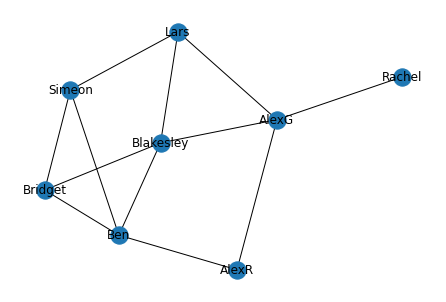

In [63]:
nx.draw_spring(this_network.graph,with_labels=True)